In [ ]:
## install required packages
!pip install swig
!pip install wrds
!pip install pyportfolioopt
!pip install --upgrade ipykernel
## install finrl library
!pip install -q condacolab
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

## Preprocessing

In [183]:
%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools
import pandas as pd

### Create Folders

from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

TRAIN_START_DATE = '2010-01-04'
TRAIN_END_DATE = '2021-10-01'
TRADE_START_DATE = '2021-10-01'
TRADE_END_DATE = '2023-05-05'

tickers = ['XLB','XLE','XLF','XLI','XLK','XLP','XLU','XLV','XLY']

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = tickers).fetch_data()

df.sort_values(['date','tic'],ignore_index=True).head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (30213, 8)


date       open       high        low      close    volume  tic  day
0  2010-01-04  33.580002  34.020000  33.450001  25.488928   7567500  XLB    0
1  2010-01-04  57.919998  58.810001  57.790001  38.080162  16928400  XLE    0
2  2010-01-04  11.795288  11.965881  11.770918   9.385945  92942347  XLF    0
3  2010-01-04  28.090000  28.320000  27.959999  21.880190   7471500  XLI    0
4  2010-01-04  23.139999  23.290001  23.100000  19.150225   8449400  XLK    0

In [3]:
#split data ticker wise
df_XLB = df[df['tic']=='XLB'][['date','tic','close']]
df_XLE = df[df['tic']=='XLE'][['date','tic','close']]
df_XLF = df[df['tic']=='XLF'][['date','tic','close']]
df_XLI = df[df['tic']=='XLI'][['date','tic','close']]
df_XLK = df[df['tic']=='XLK'][['date','tic','close']]
df_XLP = df[df['tic']=='XLP'][['date','tic','close']]
df_XLU = df[df['tic']=='XLU'][['date','tic','close']]
df_XLV = df[df['tic']=='XLV'][['date','tic','close']]
df_XLY = df[df['tic']=='XLY'][['date','tic','close']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# Dlinear
D = pd.DataFrame({'XLB':df_XLB['close'].values,
                    'XLE':df_XLE['close'].values,
                    'XLF':df_XLF['close'].values,
                    'XLI':df_XLI['close'].values,
                    'XLK':df_XLK['close'].values,
                    'XLP':df_XLP['close'].values,
                    'XLU':df_XLU['close'].values,
                    'XLV':df_XLV['close'].values,
                    'XLY':df_XLY['close'].values},index=df_XLB['date'].values)

D.head()

XLB        XLE       XLF        XLI        XLK        XLP  \
2010-01-04  25.488926  38.080177  9.385944  21.880180  19.150225  18.718466   
2010-01-05  25.571346  38.390965  9.558456  21.957451  19.125538  18.725473   
2010-01-06  26.005892  38.850704  9.577625  22.003805  18.911566  18.711445   
2010-01-07  25.803596  38.792431  9.782081  22.243319  18.837503  18.711445   
2010-01-08  26.163239  39.044956  9.724576  22.598709  18.960941  18.648277   

                  XLU        XLV        XLY  
2010-01-04  19.481915  25.213634  25.227169  
2010-01-05  19.249990  24.966358  25.319672  
2010-01-06  19.362825  25.221619  25.353300  
2010-01-07  19.275064  25.309353  25.563526  
2010-01-08  19.256262  25.349237  25.555117

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/drive


In [27]:
D = pd.read_csv('/content/drive/MyDrive/kubig_financial/D.csv')
D.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
D.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date        XLB        XLE       XLF        XLI        XLK  \
0  2010-01-04  25.488928  38.080162  9.385947  21.880188  19.150221   
1  2010-01-05  25.571354  38.390972  9.558456  21.957457  19.125528   
2  2010-01-06  26.005892  38.850708  9.577625  22.003801  18.911566   
3  2010-01-07  25.803612  38.792439  9.782079  22.243311  18.837500   
4  2010-01-08  26.163239  39.044956  9.724579  22.598709  18.960951   

         XLP        XLU        XLV        XLY  
0  18.718464  19.481915  25.213638  25.227169  
1  18.725483  19.249992  24.966366  25.319664  
2  18.711449  19.362823  25.221615  25.353292  
3  18.711449  19.275064  25.309351  25.563526  
4  18.648277  19.256264  25.349237  25.555117

In [149]:
TRAIN_END_DATE = '2021-10-01'
TRADE_START_DATE = '2021-10-01'
TRADE_END_DATE = '2023-05-01'

TRAIN_VAL_DATE = '2020-01-03'
TRADE_VAL_DATE = '2023-01-04'

In [152]:
TRAIN_END_INDEX = D[D.date==TRAIN_END_DATE].index[0]
TRADE_START_INDEX = D[D.date==TRAIN_END_DATE].index[0]
TRADE_END_INDEX = D[D.date==TRADE_END_DATE].index[0]

TRAIN_VAL_INDEX = D[D.date==TRAIN_VAL_DATE].index[0]
TRADE_VAL_INDEX = D[D.date==TRADE_VAL_DATE].index[0]

print(TRAIN_END_INDEX)
print(TRADE_END_INDEX)

2957
3353


In [162]:
train_df = D.loc[:TRAIN_END_INDEX]
test_df = D.loc[TRADE_START_INDEX:TRADE_END_INDEX]
test_df.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [163]:
test_df.head()

date        XLB        XLE        XLF        XLI         XLK  \
0  2021-10-01  77.827316  50.451199  37.005863  96.721664  149.482285   
1  2021-10-04  77.488388  51.275818  36.685760  96.195053  146.020630   
2  2021-10-05  78.175919  51.575668  37.403564  97.267784  148.101547   
3  2021-10-06  78.030670  51.032177  37.442368  97.696877  149.068054   
4  2021-10-07  79.047447  51.425747  37.665474  98.457550  150.429031   

         XLP        XLU         XLV         XLY  
0  66.495392  61.087296  124.416832  178.426147  
1  66.283440  61.928818  122.521217  177.014908  
2  66.620644  61.775818  123.254059  177.725464  
3  67.266129  62.732098  123.029320  178.287964  
4  67.564796  62.397396  124.661110  181.061081

### Preprocessing Code

In [251]:
def standardization(train_df, test_df, not_col):
    train_df_ = train_df.copy()
    test_df_ = test_df.copy()
    col =  [col for col in list(train_df.columns) if col not in [not_col]]
    mean_list = []
    std_list = []
    for x in col:
        mean = train_df[x].mean()
        std = train_df[x].std()
        mean_list.append(mean)
        std_list.append(std)
        train_df_.loc[:, x] = (train_df_[x] - mean) / std
        test_df_.loc[:, x] = (test_df_[x] - mean) / std
    return train_df_, test_df_, mean_list, std_list

def time_slide_df(df, window_size, forcast_size, date, target):
    df_ = df.copy()
    data_list = []
    dap_list = []
    date_list = []
    for idx in range(0, df_.shape[0]-window_size-forcast_size+1):
        x = df_.loc[idx:idx+window_size-1, target].values.reshape(window_size, 1)
        y = df_.loc[idx+window_size:idx+window_size+forcast_size-1, target].values
        date_ = df_.loc[idx+window_size:idx+window_size+forcast_size-1, date].values
        data_list.append(x)
        dap_list.append(y)
        date_list.append(date_)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32'), np.array(date_list)

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

###DLinear Code

In [252]:
class moving_avg(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class series_decomp(torch.nn.Module):
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        residual = x - moving_mean
        return moving_mean, residual
        
class LTSF_DLinear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, kernel_size, individual, feature_size):
        super(LTSF_DLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.decompsition = series_decomp(kernel_size)
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear_Seasonal = torch.nn.ModuleList()
            self.Linear_Trend = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Trend.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Trend[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
                self.Linear_Seasonal.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Seasonal[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
        else:
            self.Linear_Trend = torch.nn.Linear(self.window_size, self.forcast_size)
            self.Linear_Trend.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
            self.Linear_Seasonal = torch.nn.Linear(self.window_size,  self.forcast_size)
            self.Linear_Seasonal.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))

    def forward(self, x):
        trend_init, seasonal_init = self.decompsition(x)
        trend_init, seasonal_init = trend_init.permute(0,2,1), seasonal_init.permute(0,2,1)
        if self.individual:
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.forcast_size], dtype=trend_init.dtype).to(trend_init.device)
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.forcast_size], dtype=seasonal_init.dtype).to(seasonal_init.device)
            for idx in range(self.channels):
                trend_output[:, idx, :] = self.Linear_Trend[idx](trend_init[:, idx, :])
                seasonal_output[:, idx, :] = self.Linear_Seasonal[idx](seasonal_init[:, idx, :])                
        else:
            trend_output = self.Linear_Trend(trend_init)
            seasonal_output = self.Linear_Seasonal(seasonal_init)
        x = seasonal_output + trend_output
        return x.permute(0,2,1)

## Execution Code

In [254]:
### parameters
window_size = 72
forcast_size= 1
batch_size = 32
targets = list(D.columns)[1:]
date = 'date'

train_loss_list = []
valid_loss_list = []
test_loss_list = []
dlinear_prediction = []
epoch = 20
lr = 0.001
###############


### 데이터 정규화
train_df_fe, test_df_fe, mean_list, std_list = standardization(train_df, test_df, date)

for target in targets:
  ### timestep 지정
  train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forcast_size, date, target)
  test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forcast_size, date, target)

  ### DataLoader
  train_ds = Data(train_x[:TRAIN_VAL_INDEX], train_y[:TRAIN_VAL_INDEX])
  valid_ds = Data(train_x[TRADE_VAL_INDEX:], train_y[TRADE_VAL_INDEX:])
  test_ds = Data(test_x, test_y)

  train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=True)
  valid_dl = DataLoader(valid_ds, batch_size = batch_size, shuffle=False)
  test_dl  = DataLoader(test_ds,  batch_size = batch_size, shuffle=False)


  ### Dlinear
  DLinear_model = LTSF_DLinear(
      window_size=window_size,
      forcast_size=forcast_size,
      kernel_size=25,
      individual=False,
      feature_size=1,
  )
  criterion = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr)
  max_loss = 999999999

  ### training
  for epoch in tqdm(range(1, epoch+1)):
      
    loss_list = []
    DLinear_model.train()
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = DLinear_model(data)
        loss = criterion(output, target.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())    
    train_loss_list.append(np.mean(loss_list))

    DLinear_model.eval()
    valid_loss = 0
    test_loss = 0
    with torch.no_grad():
      if len(valid_dl) > 0:
          for data, target in valid_dl:
              output = DLinear_model(data)
              valid_loss += criterion(output, target.unsqueeze(-1)).item()
          valid_loss /= len(valid_dl)
          valid_loss_list.append(valid_loss)
      if len(test_dl) > 0:         
          for data, target in test_dl:
              output = DLinear_model(data)
              test_loss += criterion(output, target.unsqueeze(-1)).item()
          test_loss /= len(test_dl)
          test_loss_list.append(test_loss)

    if valid_loss < max_loss:
        torch.save(DLinear_model, f'DLinear_model_{target}.pth')
        max_loss = valid_loss
        print("valid_loss={:.3f}, test_loss={:.3f}, Model Saved".format(valid_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = np.mean(loss_list)
        dlinear_best_valid_loss = valid_loss
        dlinear_best_test_loss = test_loss

    print("epoch = {}, train_loss: {:.3f}, valid_loss: {:.3f}, test_loss: {:.3f}".format(epoch, np.mean(loss_list), valid_loss, test_loss))


  ### predict
  best_model = torch.load(f"DLinear_model_{target}.pth")

  # 예측 모드로 설정
  best_model.eval()
  predictions = []
  
  with torch.no_grad():
      for data, target in test_dl:
          output = best_model(data)
          predictions.append(output.squeeze().tolist())
  
  pred = list(itertools.chain(*predictions))
  dlinear_prediction.append(pred)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  5%|▌         | 1/20 [00:00<00:05,  3.46it/s]

valid_loss=0.000, test_loss=0.055, Model Saved
epoch = 1, train_loss: 0.034, valid_loss: 0.000, test_loss: 0.055


 10%|█         | 2/20 [00:00<00:05,  3.60it/s]

epoch = 2, train_loss: 0.008, valid_loss: 0.000, test_loss: 0.031


 15%|█▌        | 3/20 [00:00<00:04,  3.49it/s]

epoch = 3, train_loss: 0.004, valid_loss: 0.000, test_loss: 0.023


 20%|██        | 4/20 [00:01<00:04,  3.48it/s]

epoch = 4, train_loss: 0.003, valid_loss: 0.000, test_loss: 0.016


 25%|██▌       | 5/20 [00:01<00:04,  3.32it/s]

epoch = 5, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.013


 30%|███       | 6/20 [00:02<00:06,  2.23it/s]

epoch = 6, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.011


 35%|███▌      | 7/20 [00:03<00:07,  1.73it/s]

epoch = 7, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.014


 40%|████      | 8/20 [00:03<00:07,  1.67it/s]

epoch = 8, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.010


 45%|████▌     | 9/20 [00:04<00:05,  1.97it/s]

epoch = 9, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.009


 50%|█████     | 10/20 [00:04<00:04,  2.24it/s]

epoch = 10, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.009


 55%|█████▌    | 11/20 [00:04<00:03,  2.52it/s]

epoch = 11, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.010


 60%|██████    | 12/20 [00:04<00:02,  2.73it/s]

epoch = 12, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008


 65%|██████▌   | 13/20 [00:05<00:02,  2.90it/s]

epoch = 13, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.009


 70%|███████   | 14/20 [00:05<00:01,  3.04it/s]

epoch = 14, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.009


 75%|███████▌  | 15/20 [00:05<00:01,  3.13it/s]

epoch = 15, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.009


 80%|████████  | 16/20 [00:06<00:01,  2.98it/s]

epoch = 16, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008


 85%|████████▌ | 17/20 [00:06<00:00,  3.30it/s]

epoch = 17, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.009


 90%|█████████ | 18/20 [00:06<00:00,  3.28it/s]

epoch = 18, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008


 95%|█████████▌| 19/20 [00:06<00:00,  3.33it/s]

epoch = 19, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008


100%|██████████| 20/20 [00:07<00:00,  2.74it/s]

epoch = 20, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008



 10%|█         | 2/20 [00:00<00:03,  5.62it/s]

valid_loss=0.000, test_loss=0.179, Model Saved
epoch = 1, train_loss: 0.064, valid_loss: 0.000, test_loss: 0.179
epoch = 2, train_loss: 0.024, valid_loss: 0.000, test_loss: 0.118


 20%|██        | 4/20 [00:00<00:02,  5.97it/s]

epoch = 3, train_loss: 0.015, valid_loss: 0.000, test_loss: 0.092
epoch = 4, train_loss: 0.011, valid_loss: 0.000, test_loss: 0.084


 30%|███       | 6/20 [00:01<00:02,  6.12it/s]

epoch = 5, train_loss: 0.009, valid_loss: 0.000, test_loss: 0.054
epoch = 6, train_loss: 0.008, valid_loss: 0.000, test_loss: 0.045


 40%|████      | 8/20 [00:01<00:01,  6.06it/s]

epoch = 7, train_loss: 0.008, valid_loss: 0.000, test_loss: 0.040
epoch = 8, train_loss: 0.008, valid_loss: 0.000, test_loss: 0.038


 50%|█████     | 10/20 [00:01<00:01,  6.14it/s]

epoch = 9, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.040
epoch = 10, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.040


 60%|██████    | 12/20 [00:01<00:01,  6.21it/s]

epoch = 11, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.040
epoch = 12, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.040


 70%|███████   | 14/20 [00:02<00:00,  6.12it/s]

epoch = 13, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.043
epoch = 14, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.036


 80%|████████  | 16/20 [00:02<00:00,  6.02it/s]

epoch = 15, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.037
epoch = 16, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.045


 90%|█████████ | 18/20 [00:02<00:00,  6.02it/s]

epoch = 17, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.040
epoch = 18, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.036


100%|██████████| 20/20 [00:03<00:00,  6.05it/s]

epoch = 19, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.036
epoch = 20, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.040



 10%|█         | 2/20 [00:00<00:03,  5.83it/s]

valid_loss=0.000, test_loss=0.036, Model Saved
epoch = 1, train_loss: 0.019, valid_loss: 0.000, test_loss: 0.036
epoch = 2, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.022


 20%|██        | 4/20 [00:00<00:02,  6.02it/s]

epoch = 3, train_loss: 0.004, valid_loss: 0.000, test_loss: 0.018
epoch = 4, train_loss: 0.003, valid_loss: 0.000, test_loss: 0.014


 30%|███       | 6/20 [00:00<00:02,  6.04it/s]

epoch = 5, train_loss: 0.003, valid_loss: 0.000, test_loss: 0.011
epoch = 6, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.010


 40%|████      | 8/20 [00:01<00:01,  6.12it/s]

epoch = 7, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.008
epoch = 8, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.008


 50%|█████     | 10/20 [00:01<00:01,  5.94it/s]

epoch = 9, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007
epoch = 10, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007


 60%|██████    | 12/20 [00:01<00:01,  5.97it/s]

epoch = 11, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006
epoch = 12, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007


 70%|███████   | 14/20 [00:02<00:01,  5.97it/s]

epoch = 13, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006
epoch = 14, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006


 80%|████████  | 16/20 [00:02<00:00,  6.08it/s]

epoch = 15, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006
epoch = 16, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007


 90%|█████████ | 18/20 [00:02<00:00,  5.97it/s]

epoch = 17, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006
epoch = 18, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006


100%|██████████| 20/20 [00:03<00:00,  5.99it/s]

epoch = 19, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006
epoch = 20, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006



  5%|▌         | 1/20 [00:00<00:02,  6.35it/s]

valid_loss=0.000, test_loss=0.024, Model Saved
epoch = 1, train_loss: 0.013, valid_loss: 0.000, test_loss: 0.024


 10%|█         | 2/20 [00:00<00:04,  4.37it/s]

epoch = 2, train_loss: 0.006, valid_loss: 0.000, test_loss: 0.017


 15%|█▌        | 3/20 [00:00<00:04,  4.04it/s]

epoch = 3, train_loss: 0.004, valid_loss: 0.000, test_loss: 0.014


 20%|██        | 4/20 [00:00<00:04,  3.96it/s]

epoch = 4, train_loss: 0.003, valid_loss: 0.000, test_loss: 0.011


 25%|██▌       | 5/20 [00:01<00:03,  3.83it/s]

epoch = 5, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.008


 30%|███       | 6/20 [00:01<00:03,  3.76it/s]

epoch = 6, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.009


 35%|███▌      | 7/20 [00:01<00:03,  3.76it/s]

epoch = 7, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007


 40%|████      | 8/20 [00:02<00:03,  3.69it/s]

epoch = 8, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008


 45%|████▌     | 9/20 [00:02<00:03,  3.64it/s]

epoch = 9, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006


 50%|█████     | 10/20 [00:02<00:02,  3.67it/s]

epoch = 10, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


 55%|█████▌    | 11/20 [00:02<00:02,  3.73it/s]

epoch = 11, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


 60%|██████    | 12/20 [00:03<00:02,  3.72it/s]

epoch = 12, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


 65%|██████▌   | 13/20 [00:03<00:01,  3.68it/s]

epoch = 13, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


 70%|███████   | 14/20 [00:03<00:01,  3.67it/s]

epoch = 14, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006


 75%|███████▌  | 15/20 [00:04<00:01,  3.15it/s]

epoch = 15, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


 80%|████████  | 16/20 [00:04<00:01,  2.73it/s]

epoch = 16, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


 85%|████████▌ | 17/20 [00:05<00:01,  2.39it/s]

epoch = 17, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007


 90%|█████████ | 18/20 [00:05<00:01,  1.96it/s]

epoch = 18, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


 95%|█████████▌| 19/20 [00:06<00:00,  1.95it/s]

epoch = 19, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


100%|██████████| 20/20 [00:07<00:00,  2.81it/s]

epoch = 20, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005



  5%|▌         | 1/20 [00:00<00:05,  3.40it/s]

valid_loss=0.000, test_loss=0.046, Model Saved
epoch = 1, train_loss: 0.005, valid_loss: 0.000, test_loss: 0.046


 10%|█         | 2/20 [00:00<00:05,  3.33it/s]

epoch = 2, train_loss: 0.003, valid_loss: 0.000, test_loss: 0.049


 15%|█▌        | 3/20 [00:00<00:04,  3.42it/s]

epoch = 3, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.024


 25%|██▌       | 5/20 [00:01<00:03,  4.04it/s]

epoch = 4, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.031
epoch = 5, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.015


 35%|███▌      | 7/20 [00:01<00:02,  4.94it/s]

epoch = 6, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.012
epoch = 7, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.012


 45%|████▌     | 9/20 [00:01<00:01,  5.57it/s]

epoch = 8, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.018
epoch = 9, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.011


 55%|█████▌    | 11/20 [00:02<00:01,  5.77it/s]

epoch = 10, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.009
epoch = 11, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.009


 65%|██████▌   | 13/20 [00:02<00:01,  5.87it/s]

epoch = 12, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008
epoch = 13, train_loss: 0.000, valid_loss: 0.000, test_loss: 0.012


 75%|███████▌  | 15/20 [00:02<00:00,  6.06it/s]

epoch = 14, train_loss: 0.000, valid_loss: 0.000, test_loss: 0.010
epoch = 15, train_loss: 0.000, valid_loss: 0.000, test_loss: 0.010


 85%|████████▌ | 17/20 [00:03<00:00,  6.04it/s]

epoch = 16, train_loss: 0.000, valid_loss: 0.000, test_loss: 0.008
epoch = 17, train_loss: 0.000, valid_loss: 0.000, test_loss: 0.008


 95%|█████████▌| 19/20 [00:03<00:00,  6.04it/s]

epoch = 18, train_loss: 0.000, valid_loss: 0.000, test_loss: 0.008
epoch = 19, train_loss: 0.000, valid_loss: 0.000, test_loss: 0.008


100%|██████████| 20/20 [00:03<00:00,  5.23it/s]


epoch = 20, train_loss: 0.000, valid_loss: 0.000, test_loss: 0.009


  5%|▌         | 1/20 [00:00<00:07,  2.51it/s]

valid_loss=0.000, test_loss=0.026, Model Saved
epoch = 1, train_loss: 0.009, valid_loss: 0.000, test_loss: 0.026


 10%|█         | 2/20 [00:00<00:06,  2.71it/s]

epoch = 2, train_loss: 0.005, valid_loss: 0.000, test_loss: 0.026


 20%|██        | 4/20 [00:01<00:04,  3.92it/s]

epoch = 3, train_loss: 0.003, valid_loss: 0.000, test_loss: 0.013
epoch = 4, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.010


 30%|███       | 6/20 [00:01<00:02,  5.08it/s]

epoch = 5, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.008
epoch = 6, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007


 40%|████      | 8/20 [00:01<00:02,  5.42it/s]

epoch = 7, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006
epoch = 8, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008


 50%|█████     | 10/20 [00:02<00:01,  5.69it/s]

epoch = 9, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.004
epoch = 10, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006


 60%|██████    | 12/20 [00:02<00:01,  5.95it/s]

epoch = 11, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.004
epoch = 12, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.004


 70%|███████   | 14/20 [00:02<00:01,  5.94it/s]

epoch = 13, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.004
epoch = 14, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003


 80%|████████  | 16/20 [00:03<00:00,  5.94it/s]

epoch = 15, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.004
epoch = 16, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003


 90%|█████████ | 18/20 [00:03<00:00,  6.06it/s]

epoch = 17, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005
epoch = 18, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003


100%|██████████| 20/20 [00:03<00:00,  5.24it/s]

epoch = 19, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005
epoch = 20, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003



 10%|█         | 2/20 [00:00<00:02,  6.08it/s]

valid_loss=0.000, test_loss=0.040, Model Saved
epoch = 1, train_loss: 0.015, valid_loss: 0.000, test_loss: 0.040
epoch = 2, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.028


 20%|██        | 4/20 [00:00<00:02,  6.01it/s]

epoch = 3, train_loss: 0.005, valid_loss: 0.000, test_loss: 0.019
epoch = 4, train_loss: 0.004, valid_loss: 0.000, test_loss: 0.020


 30%|███       | 6/20 [00:00<00:02,  6.10it/s]

epoch = 5, train_loss: 0.003, valid_loss: 0.000, test_loss: 0.015
epoch = 6, train_loss: 0.003, valid_loss: 0.000, test_loss: 0.010


 40%|████      | 8/20 [00:01<00:01,  6.05it/s]

epoch = 7, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.008
epoch = 8, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.011


 50%|█████     | 10/20 [00:01<00:01,  5.89it/s]

epoch = 9, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.008
epoch = 10, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.006


 60%|██████    | 12/20 [00:01<00:01,  5.97it/s]

epoch = 11, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007
epoch = 12, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008


 65%|██████▌   | 13/20 [00:02<00:01,  6.05it/s]

epoch = 13, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006


 70%|███████   | 14/20 [00:02<00:01,  5.02it/s]

epoch = 14, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006


 75%|███████▌  | 15/20 [00:02<00:01,  4.50it/s]

epoch = 15, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007


 80%|████████  | 16/20 [00:02<00:00,  4.27it/s]

epoch = 16, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006


 85%|████████▌ | 17/20 [00:03<00:00,  4.10it/s]

epoch = 17, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


 90%|█████████ | 18/20 [00:03<00:00,  3.99it/s]

epoch = 18, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006


 95%|█████████▌| 19/20 [00:03<00:00,  3.90it/s]

epoch = 19, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007


100%|██████████| 20/20 [00:04<00:00,  4.95it/s]

epoch = 20, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007



  5%|▌         | 1/20 [00:00<00:04,  4.08it/s]

valid_loss=0.000, test_loss=0.018, Model Saved
epoch = 1, train_loss: 0.010, valid_loss: 0.000, test_loss: 0.018


 10%|█         | 2/20 [00:00<00:04,  3.84it/s]

epoch = 2, train_loss: 0.004, valid_loss: 0.000, test_loss: 0.013


 15%|█▌        | 3/20 [00:00<00:04,  3.86it/s]

epoch = 3, train_loss: 0.003, valid_loss: 0.000, test_loss: 0.009


 20%|██        | 4/20 [00:01<00:04,  3.76it/s]

epoch = 4, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.008


 25%|██▌       | 5/20 [00:01<00:03,  3.75it/s]

epoch = 5, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006


 30%|███       | 6/20 [00:01<00:03,  3.74it/s]

epoch = 6, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


 35%|███▌      | 7/20 [00:01<00:03,  3.64it/s]

epoch = 7, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006


 40%|████      | 8/20 [00:02<00:03,  3.53it/s]

epoch = 8, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006


 45%|████▌     | 9/20 [00:02<00:03,  3.48it/s]

epoch = 9, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008


 50%|█████     | 10/20 [00:02<00:02,  3.44it/s]

epoch = 10, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.004


 55%|█████▌    | 11/20 [00:03<00:02,  3.36it/s]

epoch = 11, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


 60%|██████    | 12/20 [00:03<00:02,  3.39it/s]

epoch = 12, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006


 65%|██████▌   | 13/20 [00:03<00:02,  3.38it/s]

epoch = 13, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.004


 70%|███████   | 14/20 [00:03<00:01,  3.42it/s]

epoch = 14, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.004


 75%|███████▌  | 15/20 [00:04<00:01,  3.49it/s]

epoch = 15, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.004


 80%|████████  | 16/20 [00:04<00:01,  3.50it/s]

epoch = 16, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003


 85%|████████▌ | 17/20 [00:04<00:00,  3.57it/s]

epoch = 17, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003


 90%|█████████ | 18/20 [00:05<00:00,  3.59it/s]

epoch = 18, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.004


 95%|█████████▌| 19/20 [00:05<00:00,  3.63it/s]

epoch = 19, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


100%|██████████| 20/20 [00:05<00:00,  3.57it/s]

epoch = 20, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003



 10%|█         | 2/20 [00:00<00:02,  6.15it/s]

valid_loss=0.000, test_loss=0.068, Model Saved
epoch = 1, train_loss: 0.010, valid_loss: 0.000, test_loss: 0.068
epoch = 2, train_loss: 0.004, valid_loss: 0.000, test_loss: 0.033


 20%|██        | 4/20 [00:00<00:02,  6.26it/s]

epoch = 3, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.026
epoch = 4, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.018


 30%|███       | 6/20 [00:00<00:02,  6.18it/s]

epoch = 5, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.015
epoch = 6, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.013


 40%|████      | 8/20 [00:01<00:01,  6.29it/s]

epoch = 7, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.011
epoch = 8, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.013


 50%|█████     | 10/20 [00:01<00:01,  6.42it/s]

epoch = 9, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.009
epoch = 10, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008


 60%|██████    | 12/20 [00:01<00:01,  6.06it/s]

epoch = 11, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.009
epoch = 12, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008


 70%|███████   | 14/20 [00:02<00:00,  6.19it/s]

epoch = 13, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008
epoch = 14, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007


 80%|████████  | 16/20 [00:02<00:00,  6.21it/s]

epoch = 15, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.009
epoch = 16, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007


 90%|█████████ | 18/20 [00:02<00:00,  6.12it/s]

epoch = 17, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007
epoch = 18, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007


100%|██████████| 20/20 [00:03<00:00,  6.18it/s]

epoch = 19, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007
epoch = 20, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.009


In [230]:
targets

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']

In [246]:
print(len(dlinear_prediction[0]))
print(len(test_df_fe.iloc[window_size:]))

325
325


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [247]:
len(dlinear_prediction)
test_df_pred = test_df_fe.iloc[window_size:].copy()

for i in range(len(targets)):
  test_df_pred[targets[i]] = dlinear_prediction[i]

test_df_pred.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date       XLB       XLE       XLF       XLI       XLK       XLP  \
72  2022-01-13  3.130335  0.699450  2.771857  2.475583  3.397466  2.342203   
73  2022-01-14  3.128577  0.739067  2.785532  2.478162  3.401376  2.349685   
74  2022-01-18  3.121519  0.791714  2.791806  2.477319  3.401948  2.358695   
75  2022-01-19  3.110420  0.840614  2.789774  2.471502  3.399833  2.362242   
76  2022-01-20  3.097809  0.884011  2.782068  2.462736  3.392124  2.365257   

         XLU       XLV       XLY  
72  2.196213  2.526559  3.127998  
73  2.198093  2.525115  3.131764  
74  2.202090  2.522659  3.134821  
75  2.198897  2.517073  3.136238  
76  2.198364  2.510440  3.130620

In [264]:
### destandardization
def inverse_standardization(test_df, not_col):
    test_df_ = test_df.copy()
    col = [col for col in list(train_df.columns) if col not in [not_col]]
    
    for x in range(len(targets)):
        mean = mean_list[x]
        std = std_list[x]
        test_df_.iloc[:, x+1] = (test_df_.iloc[:, x+1] * std) + mean
    
    return test_df_


test_df_pred_ds = inverse_standardization(test_df_pred, date)

In [276]:
test_df_pred_ds[180:].tail()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date        XLB        XLE        XLF        XLI         XLK  \
392  2023-04-25  80.775246  83.097680  32.819523  99.751150  145.153192   
393  2023-04-26  80.561866  83.034284  32.777525  99.604052  145.104697   
394  2023-04-27  80.285442  82.834151  32.711388  99.284641  145.000464   
395  2023-04-28  80.156669  82.769869  32.686694  99.167585  145.114344   
396  2023-05-01  80.141388  82.872641  32.677252  99.082710  145.344728   

           XLP        XLU         XLV         XLY  
392  74.168045  68.670095  131.816509  149.743375  
393  74.277509  68.678056  131.864735  149.700367  
394  74.335344  68.611609  131.742264  149.588161  
395  74.406578  68.611411  131.720408  149.569231  
396  74.470780  68.604167  131.727423  149.683807

In [277]:
test_df.tail()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date        XLB        XLE        XLF         XLI         XLK  \
392  2023-04-25  79.489998  84.660004  32.570000   98.989998  143.970001   
393  2023-04-26  78.550003  83.529999  32.259998   97.120003  146.110001   
394  2023-04-27  79.620003  83.830002  32.779999   99.040001  149.210007   
395  2023-04-28  80.550003  85.129997  33.169998  100.000000  150.830002   
396  2023-05-01  80.510002  84.169998  33.080002  100.540001  150.919998   

           XLP        XLU         XLV         XLY  
392  76.779999  69.900002  133.610001  144.429993  
393  76.180000  68.260002  131.710007  143.690002  
394  77.029999  69.080002  132.399994  147.479996  
395  77.440002  68.980003  133.529999  147.860001  
396  77.500000  69.099998  134.220001  146.399994

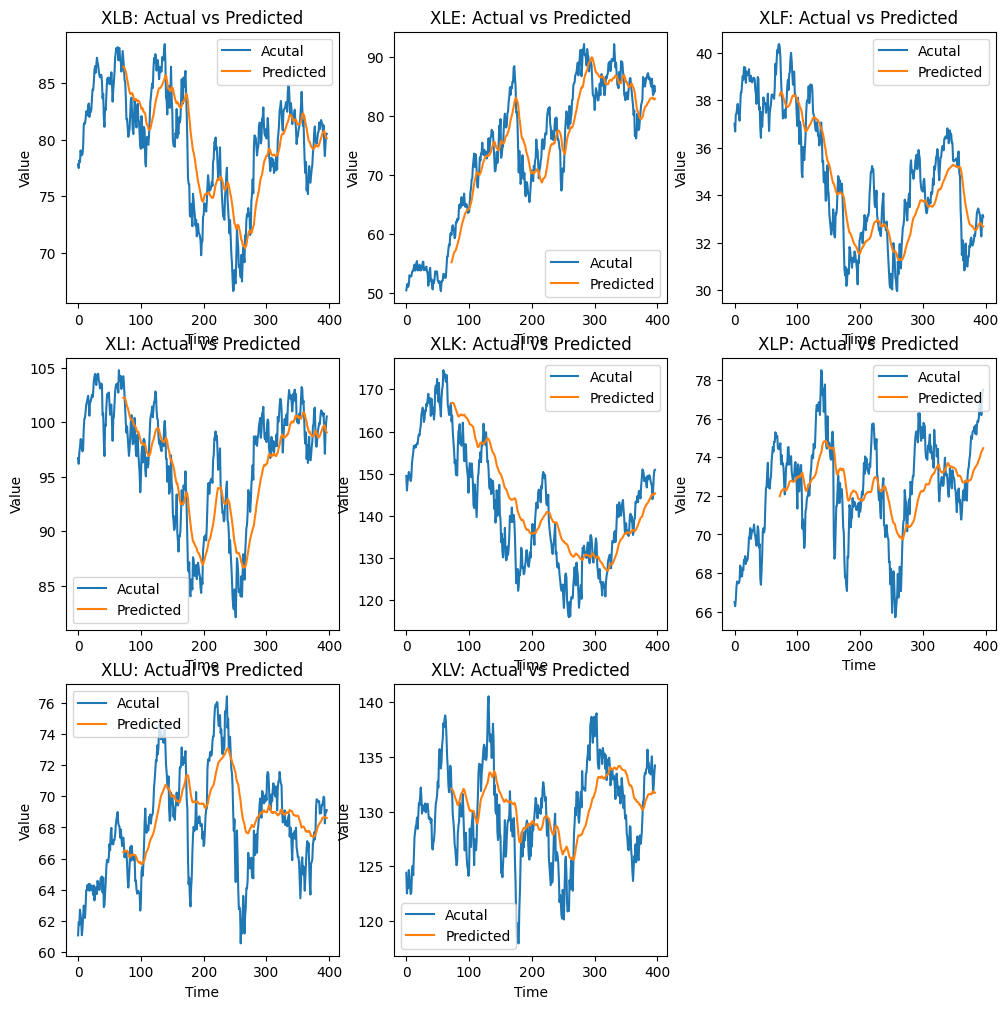

In [304]:
# 그래프 그리기
plt.figure(figsize=(12, 12))
for i in range(len(targets)-1):
  plt.subplot(3,3,i+1)
  plt.plot(test_df[targets[i]], label='Acutal')
  plt.plot(test_df_pred_ds[targets[i]], label='Predicted')
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.title(f'{targets[i]}: Actual vs Predicted')
  plt.legend()

In [306]:
test_df_pred_ds.to_csv('/content/drive/MyDrive/kubig_financial/DLinear.csv')